In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go
from fbprophet import Prophet

%matplotlib inline
plt.style.use('fivethirtyeight')

In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)

In [38]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [39]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


In [40]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

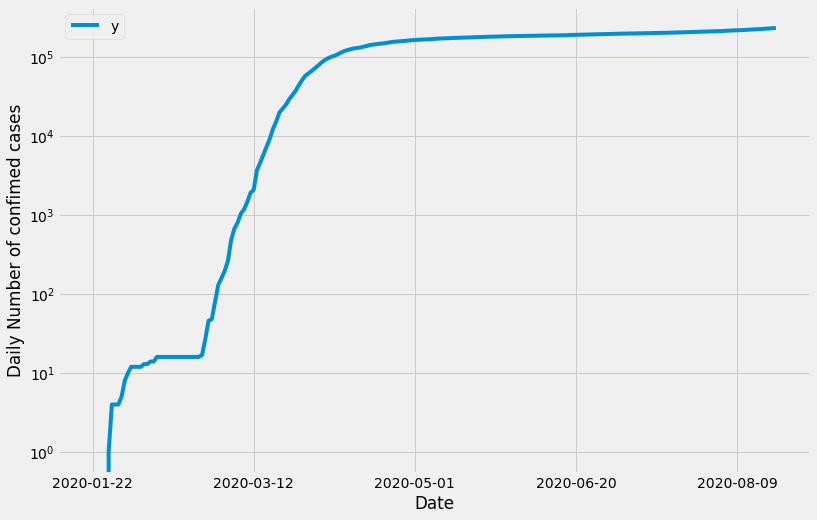

In [41]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [42]:
my_model = Prophet(growth='logistic')

In [43]:
df['cap']=1000000.
my_model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
215,2020-08-24,1000000.0
216,2020-08-25,1000000.0
217,2020-08-26,1000000.0
218,2020-08-27,1000000.0
219,2020-08-28,1000000.0


In [45]:
forecast = my_model.predict(future_dates)

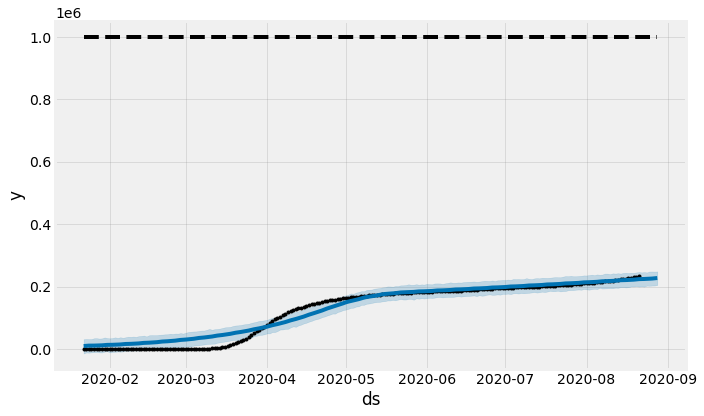

In [46]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [47]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [48]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,10071.682114,1000000.0,-14020.544868,31639.862691,10071.682114,10071.682114,-255.807780,-255.807780,-255.807780,-255.807780,-255.807780,-255.807780,0.0,0.0,0.0,9815.874334
1,2020-01-23,10365.316049,1000000.0,-10751.317982,32251.587306,10365.316049,10365.316049,58.543644,58.543644,58.543644,58.543644,58.543644,58.543644,0.0,0.0,0.0,10423.859693
2,2020-01-24,10667.418458,1000000.0,-11367.122618,31917.345556,10667.418458,10667.418458,431.189752,431.189752,431.189752,431.189752,431.189752,431.189752,0.0,0.0,0.0,11098.608209
3,2020-01-25,10978.228120,1000000.0,-10262.564872,32162.352142,10978.228120,10978.228120,110.721539,110.721539,110.721539,110.721539,110.721539,110.721539,0.0,0.0,0.0,11088.949659
4,2020-01-26,11297.990226,1000000.0,-9934.606929,34707.414045,11297.990226,11297.990226,-63.507038,-63.507038,-63.507038,-63.507038,-63.507038,-63.507038,0.0,0.0,0.0,11234.483188


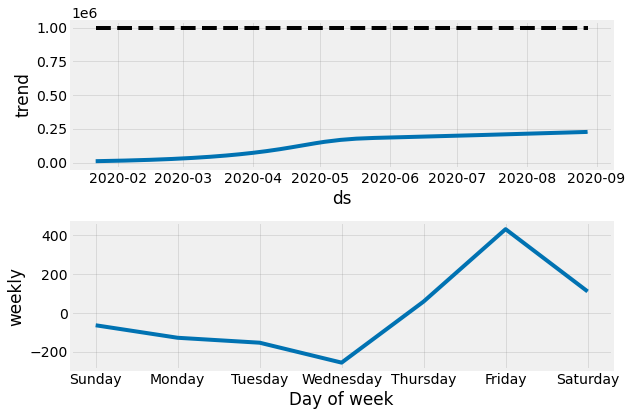

In [49]:
my_model.plot_components(forecast);

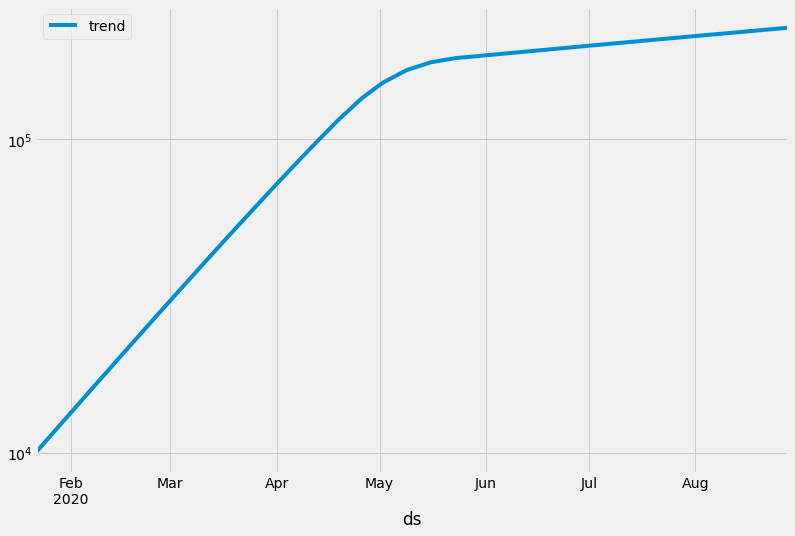

In [50]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross-Validation


In [51]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days',
                         period='1 days', 
                         horizon = '7 days')

INFO:fbprophet:Making 166 forecasts with cutoffs between 2020-03-02 00:00:00 and 2020-08-14 00:00:00


In [52]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,-1.700609,-44.156929,40.985350,196,2020-03-02
1,2020-03-04,-2.390044,-45.683034,41.167086,262,2020-03-02
2,2020-03-05,1.011665,-42.602296,44.825094,482,2020-03-02
3,2020-03-06,1.906653,-39.784983,44.380118,670,2020-03-02
4,2020-03-07,7.794951,-36.779669,50.586681,799,2020-03-02


In [53]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [54]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.570035e+09,39623.668503,31407.216271,0.210162,0.245007,0.222892
1,2 days,1.853058e+09,43047.156151,34723.977978,0.238913,0.291232,0.198795
2,3 days,2.191071e+09,46808.876159,38333.375539,0.269950,0.327700,0.198795
3,4 days,2.596723e+09,50958.046592,42241.665439,0.303156,0.371266,0.192771
4,5 days,3.086473e+09,55556.038911,46515.450566,0.337674,0.397646,0.192771
5,6 days,3.681451e+09,60674.965725,51172.775703,0.375943,0.421586,0.192771
6,7 days,4.409233e+09,66402.058208,56277.444168,0.416580,0.441999,0.192771


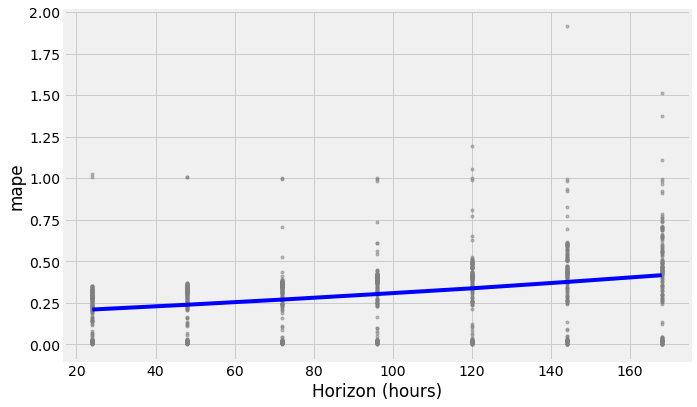

In [55]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot 

In [56]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [57]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1133,2020-08-17,220164.877180,194675.201987,245312.101276,226700,2020-08-10,7 days
1140,2020-08-18,219359.530545,199439.726684,238132.679001,228120,2020-08-11,7 days
1147,2020-08-19,222560.181078,197469.476784,248723.111157,229706,2020-08-12,7 days
1154,2020-08-20,220987.645366,199942.905847,243510.140423,231292,2020-08-13,7 days
1161,2020-08-21,224408.647722,199577.402324,248800.938130,233029,2020-08-14,7 days


In [58]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

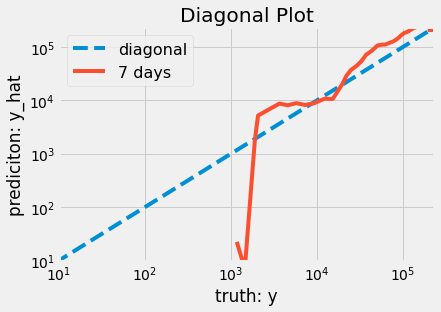

In [59]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

In [60]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean 

In [62]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean()

In [63]:
df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 141.79710498951542


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
